In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
from numpy import random, pi, array
import swarms
import pread as pds
from random import randint, seed, uniform

from swarms import YEAR, KM, MSUN, LSUN, TSUN, AU, PC, MEARTH, REARTH, MMOON, MJUP, RJUP, MICRON  

In [3]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def star_samplerM(mean=2., std=1.):
    '''
    Mstar = None
    Lstar = None
    Tstar = None
    dpl = None
    
    sample = int(random.normal(loc=mean, scale=std))
    sampled_type = 'M' + str(sample)
    for i in range(len(GPI['S_Type'])):
        if sampled_type in GPI['S_Type'][i]:
            Tstar = GPI['Teff'][i]
            Lstar = GPI['Lum'][i]*Lsun
            Mstar = GPI['Mass'][i]*Msun
            dpl = GPI['Distance_distance'][i]*pc
            break
    '''
    # Table 1 (KALTENEGGER & TRAUB) https://arxiv.org/ftp/arxiv/papers/0903/0903.3371.pdf
    ML = [7.2/100., 3.5/100., 2.3/100., 1.5/100., 0.55/100., 0.22/100., 0.09/100., 0.05/100., 0.03/100., 0.015/100.]
    MM = [0.60, 0.49, 0.44, 0.36, 0.20, 0.14, 0.10, 0.09, 0.08, 0.075]
    MT = [3800, 3600, 3400, 3250, 3100, 2800, 2600, 2500, 2400, 2300]
    sample = -1
    while sample < 0 or sample > 9:
        sample = int(random.normal(loc=mean, scale=std))
    
    return swarms.Star(M=MM[sample]*MSUN, L=ML[sample]*LSUN, T=MT[sample], d=0) # M star    

def distance_sampler(mean, std):
    s = 0
    while s <= 0:
        s = random.normal(loc=mean, scale=std)
    return s

def draw_planet(star, age, IWA=0.2, OWA=1.2):
    Mmin = 21 # Mearth (Nep)
    Mmax = 5*318 # Mearth (Jup)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 1.
    Npts = 1000
    alpha = -0.86
    Q = 0.5 # planet albedo
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None # didn't draw a planet
    else:
        # draw semimajor axis
#         amin = star.d/pc*IWA# AU
#         amax = star.d/pc*OWA # AU
        amin = 0.01 # AU
        amax = 200 # AU
        a = loguniform(amin, amax)
        #print("a in notebook: {0:.3e}".format(a))
        return swarms.Planet(star, M=ms[idx]*MEARTH , R=None, a=a*AU, Q=Q, Z='002', age=age)

def inverse_cdf(y):
    A = -0.785
    B = 0.603
    return 10**((y - A)/B)  

def age_sampler():
    y = uniform(0, 1)
    age = inverse_cdf(y)
    if age > 100:
        return age_sampler()
    return age*1e6 * YEAR

def computeQd(D, rho, fQ):
    """Compute the planetesimal strength of an object."""
    return 0.1*rho*(D/KM)**1.26/fQ

In [5]:
def aoptChar(Lstar, Mstar, Tstar, Mtot, tage):
    star = swarms.Star(Lstar, Mstar, Tstar, d=0)
    planet = draw_planet(star, tage)
    if planet is None:
        return aoptChar(Mstar, Mtot, tage) # do it again
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.3 # eta
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    f_vrel = 4./pi
  
    return aopt11(star, Mtot, 1e6*YEAR, planet, Dt, Nstr, fQ, Dc, rho, eta, charFactor=1., f_vrel=4./pi)


In [6]:
def aopt11(star, Mtot, age, planet, Dt, Nstr, fQ, Dc, rho, eta, charFactor=1., f_vrel=4./pi):
    return AU * charFactor * 65. * (fQ/5.)**0.15 * (eta/0.3)**(-1.) * (rho/1000.)**(-0.39) * (Dc/(KM * 100.))**(-0.43) * (planet.M/MJUP)**(-0.06) * (star.M/MSUN)**0.33 * (age/(1e6*YEAR))**0.24 * (Mtot/MEARTH)**0.24  

## Distribution of aopt given characteristic values

In [8]:
Mstar = 0.6*MSUN
Lstar = 0.072*LSUN
Tstar = 3800
aopt = []
for i in range(500):
    aopt.append(aoptChar(Lstar, Mstar, Tstar, MEARTH, 30e6*YEAR)/AU)

(array([128., 104.,  69.,  44.,  47.,  39.,  31.,  26.,   6.,   6.]),
 array([ 17.52355504,  33.4088777 ,  49.29420035,  65.17952301,
         81.06484567,  96.95016833, 112.83549098, 128.72081364,
        144.6061363 , 160.49145896, 176.37678162]),
 <a list of 10 Patch objects>)

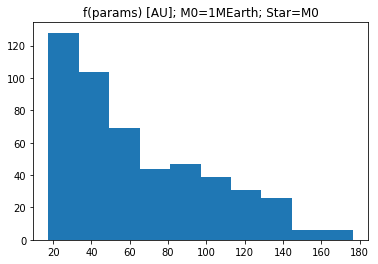

In [9]:
fig, ax = plt.subplots()
ax.set_title("f(params) [AU]; M0=1MEarth; Star=M0")
#ax.hist(np.log10(np.array(aopt)))
ax.hist(np.array(aopt))

## Sampling Stars

In [10]:
def sample(M0, lamb):
    ageChar = 30e6*YEAR
    star = swarms.Star(0.072*LSUN, 0.60*MSUN, 3800, d=0) # M0
    age = age_sampler()
    
    planet = draw_planet(star, age=age)
    if planet is None:
        return sample(M0, lamb) # do it again
    
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.3 # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    swarm = swarms.CollSwarm(star, planet, M0, Dt, Dmax, Q=Q, eta=eta, Nstr=Nstr, 
                        rho=rho, fQ=fQ, correction=True, Dmin_min=lamb, age=age)
    
    a_opt = swarm.computeaopt(t=age)
    return a_opt, age

In [11]:
seed(0)
M0 = 1*MEARTH
lamb = 1.65*MICRON
Nsamples = 300
a_opt, age = np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    a_opt[i], age[i] = sample(M0, lamb)

(array([66., 41., 39., 22., 28., 20., 30., 17., 19., 18.]),
 array([20.05503283, 28.03318353, 36.01133422, 43.98948492, 51.96763561,
        59.94578631, 67.923937  , 75.9020877 , 83.88023839, 91.85838909,
        99.83653978]),
 <a list of 10 Patch objects>)

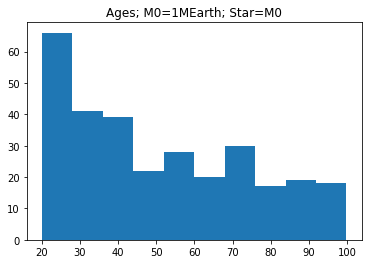

In [13]:
fig, ax = plt.subplots()
ax.set_title("Ages; M0=1MEarth; Star=M0")
ax.hist(age/YEAR/1e6)

(array([57., 62., 45., 36., 31., 28., 15.,  7., 11.,  8.]),
 array([ 33.9661886 ,  76.8295311 , 119.69287359, 162.55621609,
        205.41955858, 248.28290107, 291.14624357, 334.00958606,
        376.87292856, 419.73627105, 462.59961355]),
 <a list of 10 Patch objects>)

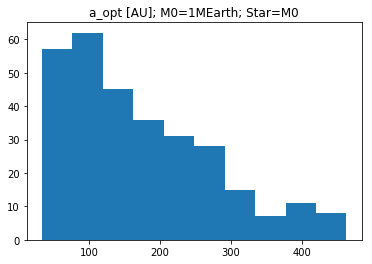

In [15]:
fig, ax = plt.subplots()
ax.set_title("a_opt [AU]; M0=1MEarth; Star=M0")
ax.hist(a_opt/AU)
#ax.hist(a_opt[a_opt < 5.e13]/AU)